# SQUANCH demonstration: quantum teleportation

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from squanch import *
import multiprocessing
% matplotlib inline

UsageError: Line magic function `%` not found.


$\renewcommand{\ket}[1]{\lvert #1 \rangle}$

This Jupyter notebook contains the source code for the [quantum teleportation demonstration](https://att-innovate.github.io/squanch/demos/quantum-teleportation.html). Refer to the documentation for more detailed explanations. 

Quantum teleportation allows two parties that share an entangled pair to transfer an arbitrary quantum state using only classical communication. This process has tremendous applicability to quantum networks, transferring fragile quantum states between distant nodes. Conceptually, quantum teleportation is the inverse of superdense coding.

In general, all quantum teleportation experiments have the same underlying structure. Two distant parties, Alice and Bob, are connected via a classical information channel and share a maximally entangled state. Alice has an unknown state $\ket{\psi}$ which she wishes to send to Bob. She performs a joint projective measurement of her state and her half of the entangled state and communicates the outcomes to Bob, who operates on his half of the entangled state accordingly to reconstruct $\ket{\psi}$. In this demo, we’ll implement the canonical two-party quantum teleportation protocol:

1. Alice generates an entangled two-particle state $\ket{AB} = \frac{1}{\sqrt{2}}\left(\ket{00}+\ket{11}\right)$, keeping half of the state and sending the other half to Bob.
2. Alice entangles her qubit $\ket{\psi}$ with her ancilla $\ket{A}$ by applying controlled-not and Hadamard operators.
3. Alice jointly measures $\ket{\psi}$ and $\ket{A}$ and communicates the outcomes to Bob through a classical channel. Bob’s qubit is now in one of four possible Bell states, one of which is $\ket{\psi}$, and he will use Alice’s two bits to recover $\ket{\psi}$.
4. Bob applies a Pauli-X operator to his qubit if Alice’s ancilla $A$ collapsed to $\ket{1}$, and he applies a Pauli-Z operator to his qubit if her state $\ket{\psi}$ collapsed to $\ket{1}$. He has thus transformed $\ket{B}\mapsto\ket{\psi}$.
\end{enumerate}

This protocol is illustrated in the circuit diagram shown in Figure

Quantum teleportation allows two parties that share an entangled pair to transfer a quantum state using classical communication. Conecptually, quantum teleportation is the inverse of superdense coding.

![Teleportation circuit](./docs/source/img/teleportation-circuit.png)

## Agent logic

In [7]:
class Alice(Agent):
    '''Alice sends qubits to Bob using a shared Bell pair'''
    
    def distribute_bell_pair(self, a, b):
        # Create a Bell pair and send one particle to Bob
        H(a)
        CNOT(a, b)
        self.qsend(bob, b)

    def teleport(self, q, a):
        # Perform the teleportation
        CNOT(q, a)
        H(q)
        # Tell Bob whether to apply Pauli-X and -Z over classical channel
        bob_should_apply_x = a.measure() # if Bob should apply X
        bob_should_apply_z = q.measure() # if Bob should apply Z
        self.csend(bob, [bob_should_apply_x, bob_should_apply_z])

    def run(self):
        for qsystem in self.qstream:
            q, a, b = qsystem.qubits # q is state to teleport, a and b are Bell pair
            self.distribute_bell_pair(a, b)
            self.teleport(q, a)

In [8]:
class Bob(Agent):
    '''Bob receives qubits from Alice and measures the results'''

    def run(self):
        measurement_results = []
        for _ in self.qstream:
            # Bob receives a qubit from Alice
            b = self.qrecv(alice) 
            # Bob receives classical instructions from alice
            should_apply_x, should_apply_z = self.crecv(alice)
            if should_apply_x: X(b)
            if should_apply_z: Z(b)
            # Measure the output state
            measurement_results.append(b.measure())
        # Put results in output object
        self.output(measurement_results)

### Simple demonstration

In this demo, we'll teleport a short list of eigenstates with no simulated errors.

In [9]:
multiprocessing.set_start_method("fork", force=True)

# Prepare the initial states
qstream = QStream(3,10) # 3 qubits per trial, 10 trials
states_to_teleport = [1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
for state, qsystem in zip(states_to_teleport, qstream):
    q = qsystem.qubit(0)
    if state == 1: X(q) # flip the qubits corresponding to 1 states

# Make and connect the agents
out = Agent.shared_output()
alice = Alice(qstream, out)
bob = Bob(qstream, out)
alice.qconnect(bob) # add a quantum channel
alice.cconnect(bob) # add a classical channel

# Run everything
alice.start()
bob.start()
alice.join()
bob.join()

print("Teleported states {}".format(states_to_teleport))
print("Received states   {}".format(out["Bob"]))

Teleported states [1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
Received states   [1, 0, 1, 0, 1, 0, 1, 0, 1, 0]


### Rotation demonstration

Here we rotate an ensemble of qubits by various angles and compare measured to expected results. Since this example takes longer to run, we'll demonstrate using the `Simulation` module to automatically monitor progress.

Alice:   0%|          | 0/12500 [00:00<?, ?it/s]

Bob:   0%|          | 0/12500 [00:00<?, ?it/s]

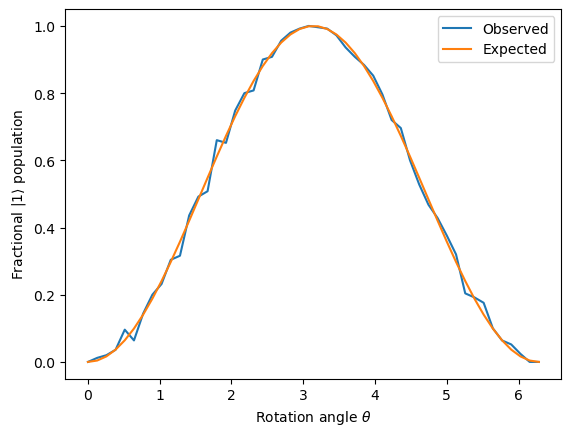

In [10]:
angles = np.linspace(0, 2 * np.pi, 50)  # RX angles to apply
num_trials = 250  # number of trials for each angle

# Prepare the initial states in the stream
qstream = QStream(3, len(angles) * num_trials)
for angle in angles:
    for _ in range(num_trials):
        q, _, _ = qstream.next().qubits
        RX(q, angle)

# Make the agents and connect with quantum and classical channels
out = Agent.shared_output()
alice = Alice(qstream, out = out)
bob = Bob(qstream, out = out)
alice.qconnect(bob)
alice.cconnect(bob)

# Run the simulation
Simulation(alice, bob).run()

# Plot the results
results = np.array(out["Bob"]).reshape((len(angles), num_trials))
observed = np.mean(results, axis = 1)
expected = np.sin(angles / 2) ** 2
plt.plot(angles, observed, label = 'Observed')
plt.plot(angles, expected, label = 'Expected')
plt.legend()
plt.xlabel("Rotation angle $\\theta$")
plt.ylabel("Fractional $\left | 1 \\right >$ population")
plt.show()